# Homework 1 

Due date : **2023-02-24 @23h55** (this is a **hard deadline**)

## Fill this cell with your names

- Name, First Name, Informatique/Mathématique-Informatique
- Name, First Name, Informatique/Mathématique-Informatique

## Carefully follow instructions

**If you don't: no evaluation!**

Write in English or French

The deliverable is a file

- `xxx_yyy.ipynb` file (jupyter notebook) or 
- `xxx_yyy.py` file (if you are using `jupytext`) or
- `xxx_yyy.qmd` file (if you are using `quarto`)

where `xxx` and `yyy` are your names, for example `lagarde_michard.ipynb`. 

The deliverable is not meant to contain cell outputs.  

The data files used to execute cells are meant to sit in the same directory as the deliverable. Use relative filepaths or urls to denote the data files.   

We **will** execute the code in your notebook: make sure that running all the cells works well. 



## Grading <i class="fa graduation-cap"></i>

Here is the way we'll assess your work

| Criterion | Points | Details |
|:----------|:-------:|:----|
|Spelling and syntax | 3 | English/French  |
|Plots correction | 3 |  Clarity / answers the question  |
|Plot style and cleanliness | 3 | Titles, legends, labels, breaks ... |
|Table wrangling | 4 | ETL, SQL like manipulations |
|Computing Statistics | 5 | SQL `goup by`  and aggregation  |
|DRY compliance | 2 | DRY principle at [Wikipedia](https://en.wikipedia.org/wiki/Don%27t_repeat_yourself)|

If we see a single (or more) `for` loop in your code: **-5 points**.  Everything can be done using high-level `pandas` methods

# Preliminaries

## Notebooks: Modus operandi

- This is a [Jupyter Notebook](https://jupyter.org).
- When you execute code within the notebook, the results appear beneath the code.
- [Jupytext](https://github.com/mwouts/jupytext)
- [Quarto](https://quarto.org) 

## Packages

- Base `Python` can do a lot. But the full power of `Python` comes from a fast growing collection of `packages`/`modules`.

- Packages are first installed (that is using `pip install` or `conda install`), and if
needed, imported during a session.

- The `docker` image you are supposed to use already offers a lot of packages. You should not need to install new packages.

- Once a package has been installed on your drive, if you want all objects exported by the package to be available in your session, you should import the package, using `from pkg import *`.

- If you just want to pick some subjects from the package,
you can use qualified names like `pkg.object_name` to access the object (function, dataset, class...)


In [1]:
# importing basic tools
import numpy as np
import pandas as pd

from pandas.api.types import CategoricalDtype

import os            # file operations
import requests      # networking
import zipfile
import io
from pathlib import Path

from datetime import date  # if needed




In [2]:
# importing plotting packages
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

In [3]:
# make pandas plotly-friendly
np.set_printoptions(precision=2, suppress=True)
%matplotlib inline
pd.options.plotting.backend = "plotly"

# Getting the data

## French data

The French data are built and made available by [INSEE](https://www.insee.fr/fr/accueil)  (French Governement Statistics Institute)

Prénoms:
- [https://www.insee.fr/fr/statistiques/fichier/2540004/nat2021_csv.zip](https://www.insee.fr/fr/statistiques/fichier/2540004/nat2021_csv.zip)

This dataset has been growing for a while. It has been considered by
social scientists for decades.  Given names are meant to give insights into a variety
of phenomena, including religious observance.

- A glimpse at the body of work can be found in [_L'archipel français_ by Jérome Fourquet, Le Seuil, 2019 ](https://www.seuil.com/ouvrage/l-archipel-francais-jerome-fourquet/9782021406023)

- Read the [File documentation](https://www.insee.fr/fr/statistiques/2540004?sommaire=4767262#documentation)

## US data 

US data may be gathered from 

[Baby Names USA from 1910 to 2021 (SSA)](https://www.kaggle.com/datasets/donkea/ssa-names-1910-2021?resource=download)

See [https://www.ssa.gov/oact/babynames/background.html](https://www.ssa.gov/oact/babynames/background.html)


## British data 

English and Welsh data can be gathered from 

[https://www.ons.gov.uk/](https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/livebirths/datasets/babynamesinenglandandwalesfrom1996?utm_source=pocket_saves)




## Download the French data

**QUESTION:** Download the data into a file which relative path is `'./nat2021_csv.zip'`

__Hints:__

- Have a look at  package [`requests`](https://requests.readthedocs.io/en/master/).
- Use magic commands to navigate across the file hierarchy and create subdirectories when needed

In [4]:
# For all countries
# Uploaded data files will be stocked in current working directory of a process + 'data'
dirpath = os.path.join(".", 'data') + os.sep
params = dict(
    furl = 'https://www.insee.fr/fr/statistiques/fichier/2540004/nat2021_csv.zip',
    burl = 'https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/birthsdeathsandmarriages/livebirths/datasets/babynamesinenglandandwalesfrom1996/1996tocurrent/babynames1996to2021.xlsx',
    usaurl = 'https://www.ssa.gov/oact/babynames/names.zip',
    dirpath = dirpath,
    timecourse = '',    
    fpath = os.path.join(dirpath, 'nat2021.csv'),                   # csv  file in 'data' folder
    bpath = os.path.join(dirpath, 'babynames1996to2021.xlsx'),      # xlsx file in 'data' folder
    upath = os.path.join(dirpath, 'usa_names') + os.sep             # a list of txt files in 'data/usa_names' folder
)

# That dict will be used later for calculate NaN's count
statistics = dict(
    countNullFr = 0,
    linesNullFr = 0,
    countNullBr = 0,
    linesNullBr = 0,
    countNullUSA = 0,
    linesNullUSA = 0
)

In [75]:
## Modify location  (this code works only in Linux, not in Windows)
#%cd {params['dirpath']}
#
## Check current directory
#%pwd
#
## Create a directory if it does not exist
#if not Path(params['dirpath']).exists():
#    %mkdir {params['dirpath']}

In [5]:
# Download and extract the zip file
# French data
if not Path(params['fpath']).exists():
    r = requests.get(params['furl'])  # Send an HTTP GET request to the URL
    print(f"Response type: {type(r)}")
    if (r.status_code == 200):
        z = zipfile.ZipFile(io.BytesIO(r.content))  # Create a zipfile object from the response content
        print(f"Zipfile type: {type(z)}")
        z.extractall(path=params['dirpath'])  # Extract the contents of the zipfile to the specified path
        print(f"File {params['fpath']} has been successfully downloaded and extracted.")
else:
    print(f"File {params['fpath']} already exists.")

Response type: <class 'requests.models.Response'>
Zipfile type: <class 'zipfile.ZipFile'>
File .\data\nat2021.csv has been successfully downloaded and extracted.


## Download US and British data 



In [6]:
# British data 

if not Path(params['bpath']).exists():
    r = requests.get(params['burl'])
    if (r.status_code == 200):
        f = open(params['bpath'],'wb')
        f.write(r.content)
        f.close()
        print(f"UK data file {params['bpath']} has been successfully downloaded.")
else:
    print(f"File {params['bpath']} already exists.")

# US data 

if not Path(params['upath']).exists():
    r = requests.get(params['usaurl'])    
    if (r.status_code == 200):        
        z = zipfile.ZipFile(io.BytesIO(r.content))       
        z.extractall(path=params['upath'])
        z.close()
        print(f"USA data files has been successfully downloaded to {params['upath']}.")
else:
    print(f"USA data files already exist in {params['upath']}.")

UK data file .\data\babynames1996to2021.xlsx has been successfully downloaded.
USA data files has been successfully downloaded to .\data\usa_names\.


## Load the French data in memory

**QUESTION:** Load the data in a `pandas` `DataFrame` called `data`

__Hints:__

- You should obtain a `Pandas dataframe` with 4 columns.
- Mind the conventions used to build the `csv` file.
- Package `pandas` provides the convenient tools.
- The dataset, though not too large, is already demanding.
- Don't hesitate to test your methods on a sample of rows method `sample()` from class `DataFrame` can be helpful.

In [7]:
# load French data in memory (1900 - 2021)
df_fr = pd.read_csv(params['fpath'], sep=';')

# Print the first few rows of the DataFrame
df_fr.head()

,sexe,preusuel,annais,nombre
0,1,_PRENOMS_RARES,1900,1249
1,1,_PRENOMS_RARES,1901,1342
2,1,_PRENOMS_RARES,1902,1330
3,1,_PRENOMS_RARES,1903,1286
4,1,_PRENOMS_RARES,1904,1430


## Load US and British data in memory

In [8]:
# load British data in memory (1996 - 2021)

# create dataframe for boys
df_boys = pd.read_excel(io = params['bpath'], engine='openpyxl', sheet_name='1', header = 7)

# take only "Name" and "Count <year>" columns and cut the word "Count"
df_boys = df_boys.iloc[:, lambda df_boys: df_boys.columns.str.contains('Count|Name', case=False)]
df_boys.columns = map(lambda x: x.replace(' Count', ''), df_boys.columns)

# collect all years in one column "Year"
df_boys = df_boys.melt(id_vars='Name', var_name='Year', value_name='Nb')

statistics['countNullBr'] += df_boys['Nb'].value_counts()['[x]']          #For Q:How many missing values (NA) have been introduced?   

# Replace Nb [x] -> NaN, drop lines with NaN and define type
df_boys = (df_boys.replace('[x]', np.nan)
                .dropna()
                .sort_values(['Name','Year'], ascending=[True,False])
                .astype({'Nb': np.int64})
                  # .sort_values(by=['Year', 'Name'])
          )

# add "Gender" column with value = 1 for all rows
df_boys.insert(0, 'Gender', 1)


# create dataframe for girls
df_girls = pd.read_excel(io = params['bpath'], engine='openpyxl', sheet_name='2', header = 7)

# take only "Name" and "Count <year>" columns and cut the word "Count"
df_girls = df_girls.iloc[:, lambda df_girls: df_girls.columns.str.contains('Count|Name', case=False)]
df_girls.columns = map(lambda x: x.replace(' Count', ''), df_girls.columns)

# collect all years in one column "Year"
df_girls = df_girls.melt(id_vars='Name', var_name='Year', value_name='Nb')

statistics['countNullBr'] += df_girls['Nb'].value_counts()['[x]']          #For Q:How many missing values (NA) have been introduced?                                                                          

# Replace Nb [x] -> NaN, drop lines with NaN and define type
df_girls = (df_girls.replace('[x]', np.nan)
                .dropna()
                .sort_values(['Name','Year'], ascending=[True,False])
                .astype({'Nb': np.int64})
                  # .sort_values(by=['Year', 'Name'])
           )
# add "Gender" column with value = 2 for all rows
df_girls.insert(0, 'Gender', 2)


# concatenate them to one DataFrame
df_br = pd.concat([df_boys, df_girls])

df_br

1
2
1
2


,Gender,Name,Year,Nb
0,1,A,2021,5
16777,1,A,2020,4
33554,1,A,2019,10
50331,1,A,2018,4
67108,1,A,2017,4
...,...,...,...,...
87831,2,Zyva,2018,5
109789,2,Zyva,2017,5
153705,2,Zyva,2015,3
285453,2,Zyva,2009,5


In [9]:
# Load USA data in memory  (1880 - 2021)

# path for directory & list of years took from filenames
pathGenerator = Path(params['upath']).rglob('*.txt')
pathsList = list(map(lambda x: x, pathGenerator))

# create DataFrame from .txt file
def fromTxtToDataFrame(filename, year):
    df = pd.read_csv(filename, sep=',', names = [ 'Name', 'Gender', 'Nb'])
    df.insert(2, 'Year', year)
    return df

# compose list of DataFrames
def doForAll():
    yearsList = list(map(lambda x: int( (str(x))[-8:-4] ), pathsList))   
    aux = list(range(len(yearsList)))
    return list(map(lambda i: fromTxtToDataFrame(pathsList[i], yearsList[i]), aux))

# concatenate all DataFrames in one
df_usa = pd.concat(doForAll(), ignore_index=True)#
df_usa = (df_usa.replace({'Gender': {'F': 2, 'M': 1}})
                 # .sort_values(by=['Gender', 'Year', 'Name'])
         )      
df_usa

,Name,Gender,Year,Nb
0,Mary,2,1880,7065
1,Anna,2,1880,2604
2,Emma,2,1880,2003
3,Elizabeth,2,1880,1939
4,Minnie,2,1880,1746
...,...,...,...,...
2052776,Zyeire,1,2021,5
2052777,Zyel,1,2021,5
2052778,Zyian,1,2021,5
2052779,Zylar,1,2021,5


## Explore the data

**QUESTION:** Look at the data, Use the attributes `columns`, `dtypes` and the methods `head`, `describe`, to get a feeling of the data.

- This dataset is supposed to report all given names used
for either sex during a year in France since 1900

- The file is made of `652 056` lines and  4 columns.

```
|-- preusuel : object
|-- nombre: int64
|-- sexe: int64
|-- annais: object
```

Each row indicates for a given `preusuel` (prénom usuel, given name), `sexe` (sex), and `annais` (année naissance, birthyear) the `nombre` (number) of babies of the given sex who were given that name during the given year.

|sexe    |preusuel     | annais|   nombre|
|:------|:--------|----:|---:|
|2     |SYLVETTE | 1953| 577|
|1   |BOUBOU   | 1979|   4|
|1   |NILS     | 1959|   3|
|2   |NICOLE   | 2003|  36|
|1   |JOSÉLITO | 2013|   4|


**QUESTION:** Compare memory usage and disk space used by data

**Hints:**

- The method `info`  prints a concise summary of a `DataFrame`.
- With optional parameter `memory_usage`, you can get an estimate
of the amount of memory used by the `DataFrame`.
- Beware that the resulting estimate depends on the argument fed.

In [10]:
print("French data")
# Display information about the DataFrame
print(df_fr.info())

# Get an estimate of the memory usage of the DataFrame
print("\nMemory usage of the DataFrame:\n", df_fr.memory_usage(deep=True))

# Get the disk space used by the data file
print("\nDisk space used by the data files = ", "%.3f" %(os.path.getsize(params['fpath'])/1000000), "MB")

French data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 686538 entries, 0 to 686537
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   sexe      686538 non-null  int64 
 1   preusuel  686536 non-null  object
 2   annais    686538 non-null  object
 3   nombre    686538 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 21.0+ MB
None

Memory usage of the DataFrame:
 Index            128
sexe         5492304
preusuel    44960397
annais      41878818
nombre       5492304
dtype: int64

Disk space used by the data files =  12.486 MB


In [11]:
print("British data")

# Display information about the DataFrame
print(df_br.info())

# Get an estimate of the memory usage of the DataFrame
print("\nMemory usage of the DataFrame:\n", df_br.memory_usage(deep=True))

# Get the disk space used by the data file
print("\nDisk space used by the data files = ", "%.3f" %(os.path.getsize(params['fpath'])/1000000), "MB")

British data
<class 'pandas.core.frame.DataFrame'>
Int64Index: 308330 entries, 0 to 307411
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Gender  308330 non-null  int64 
 1   Name    308330 non-null  object
 2   Year    308330 non-null  object
 3   Nb      308330 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 11.8+ MB
None

Memory usage of the DataFrame:
 Index      2466640
Gender     2466640
Name      19485339
Year      18808130
Nb         2466640
dtype: int64

Disk space used by the data files =  12.486 MB


In [12]:
from functools import reduce

print("USA data")

# Display information about the DataFrame
print(df_usa.info())

# Get an estimate of the memory usage of the DataFrame
print("\nMemory usage of the DataFrame:\n", df_usa.memory_usage(deep=True))

# Get the disk space used by USA data files
files = list(filter(lambda f: os.path.isfile(f) , Path(params['upath']).rglob('*')))
listSizes = list(map(lambda file: os.path.getsize(file), files))
size = reduce(lambda pr, ne: pr + ne, listSizes)

print("\nDisk space used by the data files = ", "%.3f" %(size/1000000), "MB")


USA data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2052781 entries, 0 to 2052780
Data columns (total 4 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Name    object
 1   Gender  int64 
 2   Year    int64 
 3   Nb      int64 
dtypes: int64(3), object(1)
memory usage: 62.6+ MB
None

Memory usage of the DataFrame:
 Index           128
Name      129669945
Gender     16422248
Year       16422248
Nb         16422248
dtype: int64

Disk space used by the data files =  26.598 MB


**QUESTION:** Display the output of `.describe()` with style.

In [13]:
# French data
# Compute some summary statistics about the DataFrame
summary_stats = df_fr.describe()

# Apply some styling to the summary statistics
styled_summary_stats = summary_stats.style.set_table_styles(
    [{'selector': 'th', 'props': [('background', '#7ca6db'), ('color', 'white')]}]
).format("{:.0f}").set_caption("Summary Statistics")

# Display the styled summary statistics
display(styled_summary_stats)



,sexe,nombre
count,686538,686538
mean,2,127
std,0,875
min,1,1
25%,1,4
50%,2,8
75%,2,25
max,2,53547


In [14]:
# British data
# Compute some summary statistics about the DataFrame
summary_stats = df_br.describe()

# Apply some styling to the summary statistics
styled_summary_stats = summary_stats.style.set_table_styles(
    [{'selector': 'th', 'props': [('background', '#7ca6db'), ('color', 'white')]}]
).format("{:.0f}").set_caption("Summary Statistics")

# Display the styled summary statistics
display(styled_summary_stats)


,Gender,Nb
count,308330,308330
mean,2,52
std,0,297
min,1,3
25%,1,4
50%,2,6
75%,2,16
max,2,10779


In [15]:
# USA data
# Compute some summary statistics about the DataFrame
summary_stats = df_usa.describe()

# Apply some styling to the summary statistics
styled_summary_stats = summary_stats.style.set_table_styles(
    [{'selector': 'th', 'props': [('background', '#7ca6db'), ('color', 'white')]}]
).format("{:.0f}").set_caption("Summary Statistics")

# Display the styled summary statistics
display(styled_summary_stats)


,Gender,Year,Nb
count,2052781,2052781,2052781
mean,2,1978,176
std,0,35,1493
min,1,1880,5
25%,1,1954,7
50%,2,1988,12
75%,2,2006,32
max,2,2021,99693


**QUESTION:** For each column compute the number of distinct values

In [17]:
# French data 
print ( 'distinct values for French data:\n', df_fr.nunique())

distinct values for French data:
 sexe            2
preusuel    36170
annais        123
nombre       7281
dtype: int64


In [18]:
# British data 
print ( 'distinct values for British:\n', df_br.nunique())

distinct values for British:
 Gender        2
Name      36411
Year         26
Nb         2943
dtype: int64


In [19]:
# USA data 
print ( 'distinct values for USA:\n', df_usa.nunique())

distinct values for USA:
 Name      101338
Gender         2
Year         142
Nb         13854
dtype: int64


# Transformations

## Improving the data types

**QUESTION:** Make `sexe` a category with two levels `Female` and `Male`. Call the new column `gender`. Do you see any reason why this factor should be ordered?

__Hint:__ Read [Pandas and categorical variables](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html?highlight=category)

In [20]:
# French data
df_fr['gender'] = df_fr['sexe'].map({1: 'Male', 2: 'Female'}).astype('category')

In [21]:
print('Data types for French data:\n' , df_fr.dtypes)


Data types for French data:
 sexe           int64
preusuel      object
annais        object
nombre         int64
gender      category
dtype: object


In [22]:
print("Q: Do you see any reason why this factor should be ordered?")
print("A: It might be interesting to see the names given to both girls and boys ")

df_fr[['gender', 'preusuel','nombre']].groupby(['preusuel', 'gender']).mean(numeric_only = True).round(0)


Q: Do you see any reason why this factor should be ordered?
A: It might be interesting to see the names given to both girls and boys 


nombre
preusuel gender        
A        Female     NaN
         Male       9.0
AADAM    Female     NaN
         Male       4.0
AADEL    Female     NaN
...                 ...
ÖZKAN    Male       7.0
ÖZLEM    Female     6.0
         Male       NaN
ÜMMÜ     Female     5.0
         Male       NaN

[72340 rows x 1 columns]

**QUESTION:** Compare memory usage of columns `sexe` and `gender`

In [23]:
print("Memory usage of column 'gender' = ", df_fr['gender'].memory_usage(deep=True)/1000, "kB")
print("Memory usage of column 'sexe'   =", df_fr['sexe'].memory_usage(deep=True)/1000, "kB")

Memory usage of column 'gender' =  686.898 kB
Memory usage of column 'sexe'   = 5492.432 kB


**QUESTION:** Would it be more memory-efficient to recode `sexe` using modalities `F` and `M` instead of `Male` and `Female` ?

_Insert your answer here_

> No, it wouldn't make any impact since the size is determined by the type ("category" in our case)

## Dealing with missing values

**QUESTION:** Variable `annais` class is `object`. Make `annais` of type `float`. Note that missing years are encoded as "XXXX", find a way to deal with that.

__Hint:__  As of releasing this Homework (2023-01-18), `Pandas` is not very good at managing missing values,
see [roadmap](https://pandas.pydata.org/docs/development/roadmap.html). Don't try to convert `annais` into an integer column.

In [24]:
# replace "XXXX" with NaN
df_fr['annais'] = df_fr['annais'].replace("XXXX", np.nan)

# convert annais to float
df_fr['annais'] = df_fr['annais'].astype(float)

df_fr.dtypes

sexe           int64
preusuel      object
annais       float64
nombre         int64
gender      category
dtype: object

## Rename and remove columns

**QUESTION:** Remove useless columns (now that you've created new ones, and rename them). You should end up with a dataframe with columns called `"gender"`, `"year"`, `"count"`, `"firstname`" with the following dtypes:

```python
gender        category
firstname     object
count         int64
year          float64
```

In [25]:
df_fr = (df_fr.drop(columns = 'sexe', errors = 'ignore')
                .rename(columns = {'preusuel': 'firstname', 'annais': 'year', 'nombre': 'count'})
        )
df_fr = df_fr[['gender', 'firstname', 'year', 'count']]
# Display the dtypes of the resulting dataframe
print(df_fr.dtypes)

gender       category
firstname      object
year          float64
count           int64
dtype: object


**Question:** Do the same thing for British and US data. You should eventually obtain dataframes with the same schema.  

**QUESTION:** How many missing values (NA) have been introduced? How many births are concerned?

In [26]:
# Check for missing values
print('Missing values from french data:\n', df_fr.isna().sum())

Missing values from french data:
 gender           0
firstname        2
year         37924
count            0
dtype: int64


In [27]:
# British data
def insertFemaleMale(sexe):
    if sexe == 2:
        return "Female"
    return "Male"
        
df_br['gender'] = df_br.apply(lambda x: insertFemaleMale(x.Gender), axis=1)

df_br['gender'] = df_br['gender'].astype('category')
df_br = (df_br.drop(columns = 'Gender', errors = 'ignore')
                .rename(columns = {'Name': 'firstname', 'Year': 'year', 'Nb': 'count'})
        )
df_br['year'] = df_br['year'].astype(float)
df_br = df_br[['gender', 'firstname', 'year', 'count']]
df_br

,gender,firstname,year,count
0,Male,A,2021.0,5
16777,Male,A,2020.0,4
33554,Male,A,2019.0,10
50331,Male,A,2018.0,4
67108,Male,A,2017.0,4
...,...,...,...,...
87831,Female,Zyva,2018.0,5
109789,Female,Zyva,2017.0,5
153705,Female,Zyva,2015.0,3
285453,Female,Zyva,2009.0,5


In [28]:
# USA data
df_usa['gender'] = df_usa.apply(lambda x: insertFemaleMale(x.Gender), axis=1)
df_usa['gender'] = df_usa['gender'].astype('category')
df_usa = (df_usa.drop(columns = 'Gender', errors = 'ignore')
                .rename(columns = {'Name': 'firstname', 'Year': 'year', 'Nb': 'count'})
        )
df_usa['year'] = df_usa['year'].astype(float)
df_usa = df_usa[['gender', 'firstname', 'year', 'count']]
df_usa

,gender,firstname,year,count
0,Female,Mary,1880.0,7065
1,Female,Anna,1880.0,2604
2,Female,Emma,1880.0,2003
3,Female,Elizabeth,1880.0,1939
4,Female,Minnie,1880.0,1746
...,...,...,...,...
2052776,Male,Zyeire,2021.0,5
2052777,Male,Zyel,2021.0,5
2052778,Male,Zyian,2021.0,5
2052779,Male,Zylar,2021.0,5


In [29]:
statistics['countNullFr']=df_fr.isna().sum()['year']
print(f"It was inserted:\n    {statistics['countNullFr']} NaN's for French data \n    {statistics['countNullBr']} NaN's for UK data\n    {statistics['countNullUSA']} NaN's for USA data" )


It was inserted:
    37924 NaN's for French data 
    698780 NaN's for UK data
    0 NaN's for USA data


**QUESTION:** Read the documentation and describe the origin of rows containing the missing values.

In [30]:
print("In USA data there is no need to insert NaN because their files only contain records for a particular year.\nIt means that the starting point is the year. And name is written only if someone was given this name in that year.\n\nIn the UK data, it’s the names who are the starting point: all the names of children ever given from 1996 to 2021 are listed. \nIf in any year this name was not given to anyone, NaN (labeled '[x]') is indicated. \n\nThe French data contains NaN on format 'XXXX' for privacy reasons: if some name is given less than 3 times a year, it is not published in that year, because this will make it easier to reveal the identity of the people. The number of such events for a given name is summarized and published in a column 'Year' with label 'XXXX'.")

In USA data there is no need to insert NaN because their files only contain records for a particular year.
It means that the starting point is the year. And name is written only if someone was given this name in that year.

In the UK data, it’s the names who are the starting point: all the names of children ever given from 1996 to 2021 are listed. 
If in any year this name was not given to anyone, NaN (labeled '[x]') is indicated. 

The French data contains NaN on format 'XXXX' for privacy reasons: if some name is given less than 3 times a year, it is not published in that year, because this will make it easier to reveal the identity of the people. The number of such events for a given name is summarized and published in a column 'Year' with label 'XXXX'.


In [31]:
# IMPORTANT: concatenation of 3 dataFrames

print("Three DataFrames aggregation into one")

col = 'country'
df_fr[col] = "France"
df_br[col] = "UK"
df_usa[col] = "USA"

df_total = pd.concat([df_fr, df_br, df_usa], ignore_index=True)

df_total

Three DataFrames aggregation into one


,gender,firstname,year,count,country
0,Male,_PRENOMS_RARES,1900.0,1249,France
1,Male,_PRENOMS_RARES,1901.0,1342,France
2,Male,_PRENOMS_RARES,1902.0,1330,France
3,Male,_PRENOMS_RARES,1903.0,1286,France
4,Male,_PRENOMS_RARES,1904.0,1430,France
...,...,...,...,...,...
3047644,Male,Zyeire,2021.0,5,USA
3047645,Male,Zyel,2021.0,5,USA
3047646,Male,Zyian,2021.0,5,USA
3047647,Male,Zylar,2021.0,5,USA


## Checkpointing: save your transformed dataframes

**QUESTION:** Save the transformed dataframe (retyped and renamed) to `./nat2021_csv.zip`. Try several compression methods.

In [32]:
# using zip compression
df_fr.to_csv('./babies-fr.zip', index=False, compression='zip')
df_br.to_csv('./babies-dr.zip', index=False, compression='zip')
df_usa.to_csv('./babies-us.zip', index=False, compression='zip')
df_total.to_csv('./babies-ew.zip', index=False, compression='zip')

# using gzip compression
#df_fr.to_csv('./nat2021_csv.gzip', index=False, compression='gzip')

# using bz2 compression
#df_fr.to_csv('./nat2021_csv.bz2', index=False, compression='bz2')

# using xz compression
#df_fr.to_csv('./nat2021_csv.xz', index=False, compression='xz')


**QUESTION:** Save the transformed dataframes (retyped and renamed) to `./nat2021.hdf` using `.hdf` format

In [33]:
# Save the transformed dataframe to an HDF file
df_fr.to_hdf('babies-fr.hdf', key='nat', mode='w', format="table")
df_br.to_hdf('babies-br.hdf', key='nat', mode='w', format="table")
df_usa.to_hdf( 'babies-us.hdf', key='nat', mode='w', format="table")
df_total.to_hdf( 'babies-ew.hdf', key='nat', mode='w', format="table")

At that point your working directory should look like:

```
├── homework01.py      # if you use `jupytext`
|── homework01.qmd     # if you use `quarto`
├── homework01.ipynb   # if you use `jupyter` `notebook`
├── babies-fr.hdf
├── babies-fr.zip
├── babies-us.hdf
├── babies-us.zip
├── babies-ew.hdf
├── babies-ew.zip
├── births-fr.csv
├── births-fr.hdf
```

**QUESTION:** Reload the data using `read_hdf(...)` so that the resulting dataframes  are properly typed with meaningful and homogeneous column names.

__Hint:__ use `try: ... except` to handle exceptions such as `FileNotFoundError`

In [57]:
# Reload the dataframes
try:
    df_fr = pd.read_hdf('babies-fr.hdf')
    print('babies-fr.hdf was loaded successfully')
except FileNotFoundError:
    print('babies-fr.hdf was not found')

try:
    df_us = pd.read_hdf('babies-us.hdf')
    print('babies-us.hdf was loaded successfully')
except FileNotFoundError:
    print('babies-us.hdf was not found')

try:
    df_total = pd.read_hdf('babies-ew.hdf')
    print('babies-ew.hdf was loaded successfully')
except FileNotFoundError:
    print('babies-ew.hdf was not found')
    
try:
    df_br = pd.read_hdf('babies-br.hdf')
    print('babies-br.hdf was loaded successfully')
except FileNotFoundError:
    print('babies-br.hdf was not found')

# Check the types and column names
print('\nData types for babies-fr.hdf:')
print(df_fr.dtypes)
print('\nColumn names for babies-fr.hdf:')
print(df_fr.columns)

print('\nData types for babies-br.hdf:')
print(df_br.dtypes)
print('\nColumn names for babies-br.hdf:')
print(df_br.columns)

print('\nData types for babies-us.hdf:')
print(df_us.dtypes)
print('\nColumn names for babies-us.hdf:')
print(df_us.columns)

print('\nData types for babies-ew.hdf:')
print(df_total.dtypes)
print('\nColumn names for babies-ew.hdf:')
print(df_total.columns)

babies-fr.hdf was loaded successfully
babies-us.hdf was loaded successfully
babies-ew.hdf was loaded successfully
babies-br.hdf was loaded successfully

Data types for babies-fr.hdf:
gender       category
firstname      object
year          float64
count           int64
country        object
dtype: object

Column names for babies-fr.hdf:
Index(['gender', 'firstname', 'year', 'count', 'country'], dtype='object')

Data types for babies-br.hdf:
gender       category
firstname      object
year          float64
count           int64
country        object
dtype: object

Column names for babies-br.hdf:
Index(['gender', 'firstname', 'year', 'count', 'country'], dtype='object')

Data types for babies-us.hdf:
gender       category
firstname      object
year          float64
count           int64
country        object
dtype: object

Column names for babies-us.hdf:
Index(['gender', 'firstname', 'year', 'count', 'country'], dtype='object')

Data types for babies-ew.hdf:
gender       category
firstn

## Some data "analytics" and visualization

**QUESTION**: For each year, compute the total number of Female and Male births and the proportion of Female  births among total births

__Hints:__

- Groupby operations using several columns for the groups return a dataframe with a `MultiIndex` index see [Pandas advanced](https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html)

- Have a look at `MultiIndex`, `reset_index`, `pivot`, `columns.droplevel`

In [58]:
# 1) group the data by year and gender, and sum the counts
# 2) unstack the gender level of the index to get separate columns for male and female counts
year_counts = (df_total[['year', 'gender', 'count']]
                        .groupby(['year', 'gender'])['count'].sum()
                        .unstack('gender')    
                     )

# 3) compute the total number of births for each year by adding up the male and female counts
year_counts = year_counts.reset_index(drop=True)

year_counts['total'] = year_counts['Female'] + year_counts['Male']

# 4) compute the proportion of female births among total births for each year
year_counts['proportion_female'] = year_counts['Female'] / year_counts['total'] * 100
print(year_counts.dtypes)
year_counts = year_counts.style.format({'proportion_female': '{:.2f} %'}, na_rep='proportion_female', precision=2)

# 5) print the resulting dataframe
year_counts


gender
Female                 int64
Male                   int64
total                  int64
proportion_female    float64
dtype: object


gender,Female,Male,total,proportion_female
0,90994,110490,201484,45.16 %
1,91953,100737,192690,47.72 %
2,107847,113686,221533,48.68 %
3,112319,104625,216944,51.77 %
4,129019,114442,243461,52.99 %
5,133055,107799,240854,55.24 %
6,144533,110784,255317,56.61 %
7,145982,101411,247393,59.01 %
8,178622,120851,299473,59.65 %
9,178366,110580,288946,61.73 %


**QUESTION:** Plot the proportion of female births as a function of year and French, US, en British babynames data. Compare with what you get from `births-fr.hdf`.

Don't forget: title, axes labels, ticks, scales, etc.

Because of what we did before, the `plot` method of a `DataFrame` with be rendered using `plotly`, so you can use this. But you can use also `seaborn` or any other available plotting library that you want.

__Hint:__ Mind the missing values in the `year` column

In [59]:
# For the aggregated data 

# Group the data by year and compute the proportion of female births
def transformData(df):
    rez = (df.groupby(['year', 'gender']).sum(numeric_only = True)
                                                 .unstack('gender')
                  )
    return (100 * rez['count']['Female'] / (rez['count']['Female'] + rez['count']['Male']))

prop_female = transformData(df_total)

# Plot the data
fig = px.line(prop_female, x=prop_female.index, y=prop_female.values, title='Proportion (in %) of female births by year for tree countries')
fig.update_layout(xaxis_title='Year', yaxis_title='Proportion female births', xaxis_tickmode='linear')
fig.show()


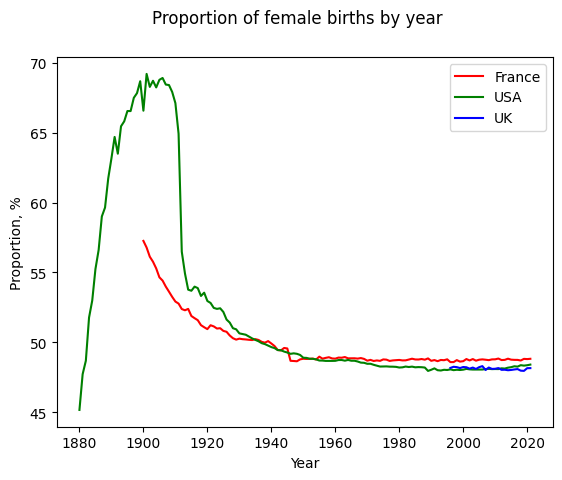

In [60]:
# For French, USA and British data

import matplotlib.pyplot as plt

prop_fr = transformData(df_fr)
prop_br = transformData(df_br)
prop_us = transformData(df_us)

fig, ax = plt.subplots()   
ax.plot(prop_fr, label='France', color='red')
ax.plot(prop_us, label='USA', color='green')
ax.plot(prop_br, label='UK', color='blue')    
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Proportion, %')
fig.suptitle('Proportion of female births by year')
plt.show()

**QUESTION:** Make any sensible comment about these plots.

> ##### Basing on this charts we can constate that 
> - In ***France***, the ratio of female births was systematically came to an equilibration from 1900 till the end of the World War II. After World War II, slightly more boys was born in France than girls.
> - In the ***UK**, on 1995-2021 the situation is similar to french one - a little bit more males was born than females.
> - In the ***United States***, the birth rate for girls far exceeded that for boys between 1884 and 1905 (up to a ratio of 3 boys to 7 girls). Since 1920 we can state the equilibration of the birth rate between boys and girls. Since '60 the tendencies are the same as in France and UK.
> It's interesting that the disproportion in the US disappears sharply in 1910-1914.
> We looked for other birth statistics researches and found no such anomalies.
> For exemple
> https://jscholarship.library.jhu.edu/bitstream/handle/1774.2/934/WP90-01_Sex_Ratio.pdf

**QUESTION:** Explore the fluctuations of sex ratio around its mean value since 1945  in the US, in France and in the Great Britain.

Plot deviations of sex ratio around its mean since 1945 as a function of time.

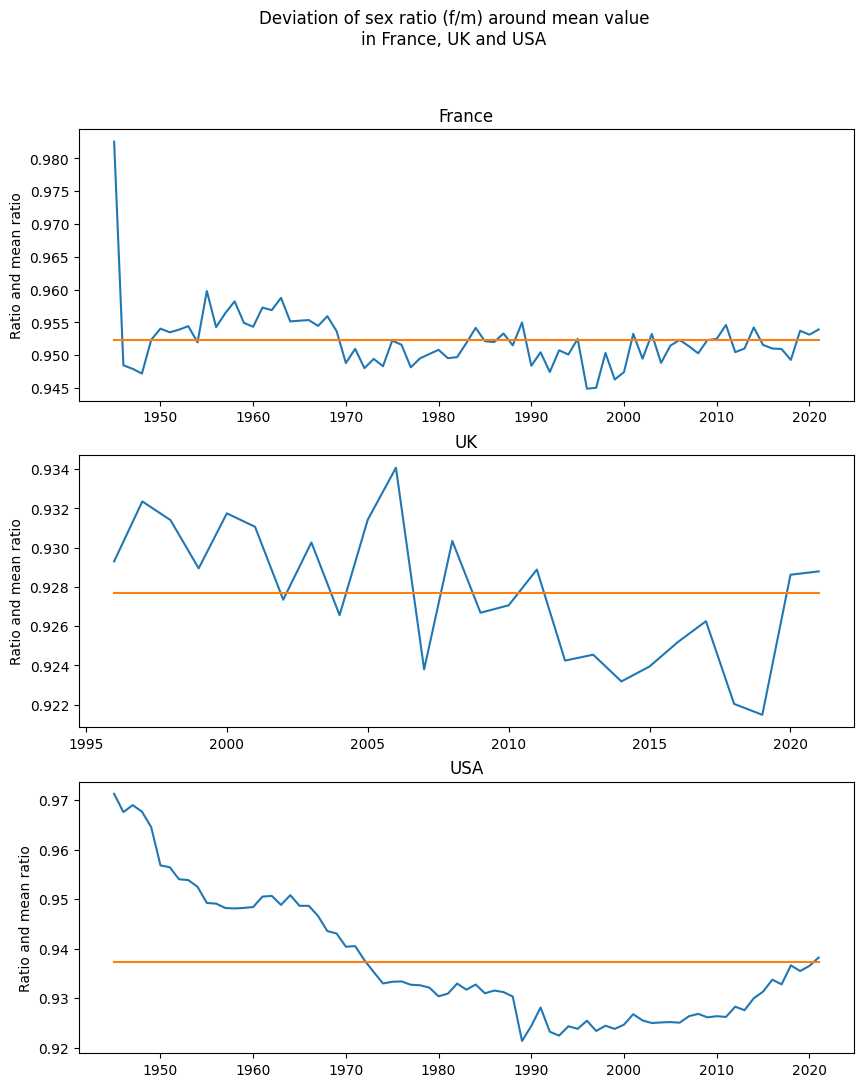

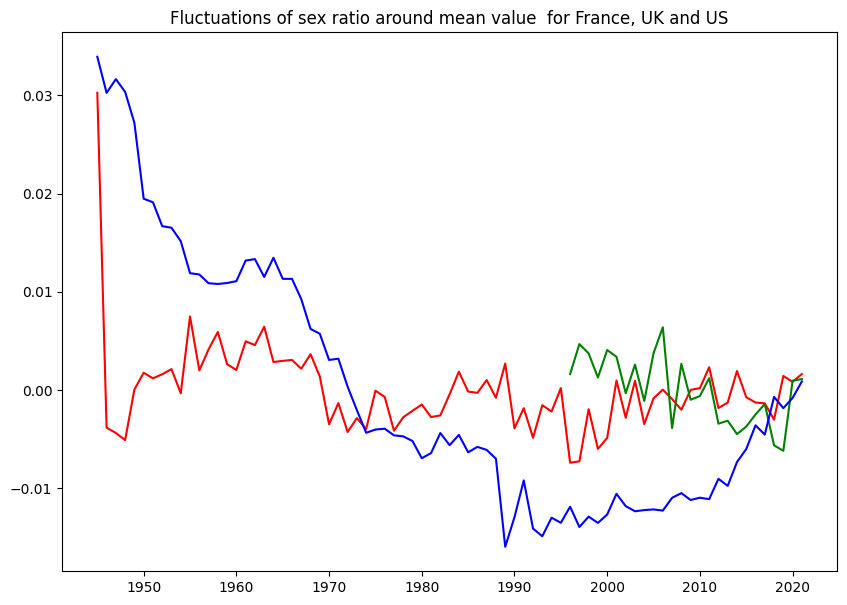

In [61]:
df_fr_1945 = df_fr[(df_fr["year"] >= 1945)]
df_br_1945 = df_br[(df_br["year"] >= 1945)]
df_us_1945 = df_us[(df_us["year"] >= 1945)]

# Group the data by year and gender, and calculate the total number of births for each group
def makeGroupBy(df):
    df = df.groupby(['year', 'gender'])['count'].sum().unstack('gender')
    df['sex_ratio'] = df['Female'] / df['Male']
    df['sex_ratio_mean'] = df['sex_ratio'].mean()
    return df

df_fr_1945 = makeGroupBy(df_fr_1945)
df_br_1945 = makeGroupBy(df_br_1945)
df_us_1945 = makeGroupBy(df_us_1945)

# ploat
fig, axs = plt.subplots(nrows= 3 , ncols= 1 )
fig.suptitle('Deviation of sex ratio (f/m) around mean value\nin France, UK and USA')
fig.set_size_inches(10, 12)

axs[0].plot(df_fr_1945.index, df_fr_1945[['sex_ratio', 'sex_ratio_mean']].values)
axs[0].set_title('France')

axs[1].plot(df_br_1945.index, df_br_1945[['sex_ratio', 'sex_ratio_mean']].values)
axs[1].set_title('UK')

axs[2].plot(df_us_1945.index, df_us_1945[['sex_ratio', 'sex_ratio_mean']].values)
axs[2].set_title('USA')


#TODO remove for
for ax in axs.flat:
    ax.set(ylabel='Ratio and mean ratio')

plt.show()

# Calculate the deviations from the mean
dev_fr = df_fr_1945['sex_ratio'] - df_fr_1945['sex_ratio_mean']
dev_br = df_br_1945['sex_ratio'] - df_br_1945['sex_ratio_mean']
dev_us = df_us_1945['sex_ratio'] - df_us_1945['sex_ratio_mean']

fig1, axs1 = plt.subplots()
fig1.set_size_inches(10, 7)

axs1.plot(dev_fr, label='France', color='red')
axs1.plot(dev_br, label='USA', color='green')
axs1.plot(dev_us, label='UK', color='blue')    
axs1.set_title('Fluctuations of sex ratio around mean value  for France, UK and US')

plt.show()

**QUESTION:**  Assume that baby gender is chosen at random according to a Bernoulli distribution with success probability $.48$, that baby genders are i.i.d. Perform simulations for sex ratios for French and US data since 1945. 

Plot the results, compare with your plots above.  

In [73]:
#p = 0.48 
#k = df_total['Female']
#n = df_total['Female'] + df_total['Male']
#bernoulli = np.random.binomial(k, p, n)

bern_fr_sep = (df_fr[(df_fr["year"] >= 1945)]).groupby(['year', 'gender'])['count'].sum()
bern_fr_all = (df_fr[(df_fr["year"] >= 1945)]).groupby(['year'])['count'].sum()

bern_fr_sep

year    gender
1945.0  Female    293281
        Male      298485
1946.0  Female    421644
        Male      444552
1947.0  Female    434496
                   ...  
2019.0  Male      378649
2020.0  Female    352148
        Male      369459
2021.0  Female    355705
        Male      372883
Name: count, Length: 154, dtype: int64

# The rise, decline and fall of firstnames

**Question:** For each year, country, gender and firstname, compute the popularity rank of the firstname among the names given to babies with that gender, in that country, in that year. The most popular name should be given rank $1$.  

In [64]:
# Group data by year, country, gender, and firstname, and sum the counts
df_fr_popularity_rank = df_fr.groupby(['year', 'gender', 'firstname'])['count'].sum().reset_index()
df_usa_popularity_rank = df_us.groupby(['year', 'gender', 'firstname'])['count'].sum().reset_index()
df_br_popularity_rank = df_br.groupby(['year', 'gender', 'firstname'])['count'].sum().reset_index()

def transformPopRank(df):
    df['popularity_rank'] = (df.groupby(['year', 'gender'])['count']
                               .rank(ascending=False)
                               .astype(int)
                            )
# Sort data by year, country, gender, firstname, and count, and then assign a rank to each firstname
transformPopRank(df_fr_popularity_rank)
transformPopRank(df_br_popularity_rank)
transformPopRank(df_usa_popularity_rank)

# Sort the data from most popular to least each year 
df_fr_popularity_rank = df_fr_popularity_rank.sort_values(['year', 'gender','popularity_rank'])
df_br_popularity_rank = df_br_popularity_rank.sort_values(['year', 'gender','popularity_rank'])
df_usa_popularity_rank = df_usa_popularity_rank.sort_values(['year', 'gender','popularity_rank'])

print('Popularity rank for French data:\n' , df_fr_popularity_rank)
print('Popularity rank for British data:\n' , df_br_popularity_rank)
print('Popularity rank for USA data:\n' , df_usa_popularity_rank)

Popularity rank for French data:
            year  gender   firstname  count  popularity_rank
21431    1900.0  Female       MARIE  48713                1
15000    1900.0  Female      JEANNE  13981                2
21311    1900.0  Female  MARGUERITE   8058                3
11289    1900.0  Female    GERMAINE   6981                4
19475    1900.0  Female      LOUISE   6696                5
...         ...     ...         ...    ...              ...
8825475  2021.0    Male        ÖZGE      0            21280
8825476  2021.0    Male       ÖZGÜR      0            21280
8825477  2021.0    Male       ÖZKAN      0            21280
8825478  2021.0    Male       ÖZLEM      0            21280
8825479  2021.0    Male        ÜMMÜ      0            21280

[8825480 rows x 5 columns]
Popularity rank for British data:
            year  gender firstname  count  popularity_rank
31834    1996.0  Female    Sophie   7087                1
7103     1996.0  Female     Chloe   6824                2
15978    


**QUESTION:** For each firstname and sex (some names may be given to girls and boys), compute the total number of times this firstname has been given during `1900-2019`. Print the top 20 firstnames given and style your result dataframe using `background_gradient` for instance.

In [65]:
# Filter data for 1900-2019
df_filtered = df_total[(df_total['year'] >= 1900) & (df_total['year'] <= 2019)]

# Group the data by firstname and sex, and sum the counts
name_counts = df_filtered.groupby(['firstname', 'gender'])['count'].sum()

# Sort the names by count, and select the top 20
top_names = name_counts.sort_values(ascending=False).head(20)

# Style the result dataframe using background_gradient
styled_top_names = top_names.to_frame().style.background_gradient()

# Display the styled dataframe
styled_top_names


,,count
firstname,gender,
James,Male,5207138
John,Male,4984048
Robert,Male,4800663
Michael,Male,4410102
William,Male,4083123
Mary,Female,3911894
David,Male,3649212
Joseph,Male,2664024
Richard,Male,2560904


## Rare firstnames

**QUESTION:** In the French data, for each sex, plot the proportion of births given `_PRENOMS_RARES` as a function of the year.

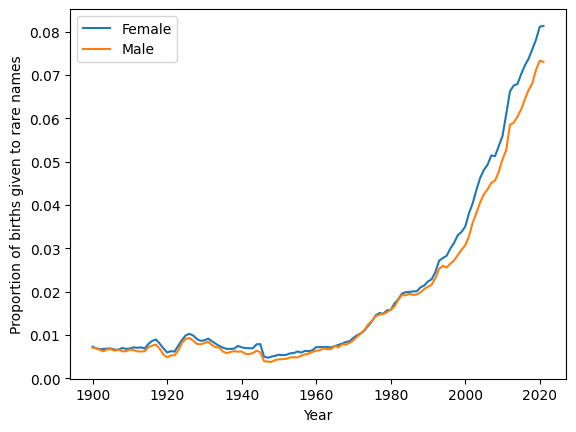

In [66]:
import matplotlib.pyplot as plt

# Filter the dataframe to only include rows where the name is rare
df_rare_names = df_fr[df_fr['firstname'] == '_PRENOMS_RARES']

# Group the rare names dataframe by year and gender and sum the counts
df_rare_names_by_year_sex = df_rare_names.groupby(['year', 'gender']).sum(numeric_only = True)

# Group the original dataframe by year and gender and sum the counts
df_total_births = df_fr.groupby(['year', 'gender']).sum(numeric_only = True)

# Calculate the proportion of births given to rare names for each year and gender
proportions = df_rare_names_by_year_sex['count'] / df_total_births['count']

# Plot the proportions as a function of year for each gender
fig, ax = plt.subplots()
   
ax.plot(proportions[:, 'Female'], label='Female')
ax.plot(proportions[:, 'Male'], label='Male')
    
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Proportion of births given to rare names')
plt.show()


# A study of the "Marie" firstname

**QUESTION:** Plot the proportion of female births given name `'MARIE'` or `'MARIE-...'` (compounded names) as a function of the year.
Proceed in such a way that the reader can see the share of compounded names. We are expecting an _area plot_.

__Hints:__

- Have a look at the `.str` accessor (to apply a string method over a whole column containing string)
- Have a look at [r-graph-gallery: stacked area](https://www.r-graph-gallery.com/stacked-area-graph.html)  and
at [ggplot documentation](https://ggplot2.tidyverse.org/reference/geom_ribbon.html). Pay attention on the way you stack the area corresponding to names matching pattern 'MARIE-.*' over or under the are corresponding to babies named 'MARIE'
- See Graphique 3, page 48, de _L'archipel français_  de J. Fourquet. Le Seuil. Essais. Vol. 898.

- Add annotation, 1st World War, Front Populaire, 2nd World War, 1968

In [72]:
# Filter the dataframe to only include female names
df_femme = df_total[df_total['gender'] == 'Female']

# Create boolean masks for 'MARIE' and 'MARIE-' names
df_marie_st = df_femme[df_femme['firstname'].str.contains('MARIE-', case=False, na=False, regex=False)]
df_marie_mid = df_femme[df_femme['firstname'].str.contains('-MARIE-', case=False, na=False, regex=False)]
df_marie_end = df_femme[df_femme['firstname'].str.contains('-MARIE', case=False, na=False, regex=False)]

df_marie_only = df_femme[df_femme['firstname'].str.contains(r'^MARIE$', case=False, na=False, regex=True)]

df_marie_compounded = pd.concat([df_marie_st, df_marie_mid, df_marie_end])
df_marie_all = pd.concat([df_marie_compounded, df_marie_only])


# Compute the total number of female births for each year
total_female_births = df_femme.groupby('year')['count'].sum()

## Compute the number of female births given the name 'MARIE' for each year
marie_only = df_marie_only.groupby('year')['count'].sum()

# Compute the number of female births given a compounded name starting with 'MARIE-' for each year
marie_compounded_births = df_marie_compounded.groupby('year')['count'].sum()


# Compute the proportion of female births given 'MARIE' or 'MARIE-' for each year
marie_proportion = (marie_only + marie_compounded_births) / total_female_births
total_female_births

## Plot the data as a stacked area plot
#plt.stackplot(df_female['year'].unique(),
#              marie_compounded_births, 
#              marie_births,
#              labels=['Marie-', 'Marie'],
#              alpha=0.7)
#
## Add a legend
#plt.legend(loc='upper left')
#
## Add x-axis labels and title
#plt.xlabel('Year')
#plt.title('Proportion of Female Births Given Name Marie or Marie-...')
#
## Add annotations for major historical events
#plt.axvline(x=1914, color='black', linestyle='--', alpha=0.5)
#plt.annotate('1st World War', xy=(1914, 0.08), xytext=(1915, 0.15),
#             arrowprops=dict(facecolor='black', arrowstyle='->'))
#plt.axvline(x=1936, color='black', linestyle='--', alpha=0.5)
#plt.annotate('Front Populaire', xy=(1936, 0.07), xytext=(1930, 0.13),
#             arrowprops=dict(facecolor='black', arrowstyle='->'))
#plt.axvline(x=1939, color='black', linestyle='--', alpha=0.5)
#plt.annotate('2nd World War', xy=(1939, 0.1), xytext=(1935, 0.17),
#             arrowprops=dict(facecolor='black', arrowstyle='->'))
#plt.axvline(x=1968, color='black', linestyle='--', alpha=0.5)
#plt.annotate('1968', xy=(1968, 0.13), xytext=(1970, 0.2),
#             arrowprops=dict(facecolor='black', arrowstyle='->'))
#
## Show the plot
#plt.show()
#
#
#

year
1880.0      90994
1881.0      91953
1882.0     107847
1883.0     112319
1884.0     129019
           ...   
2017.0    2390265
2018.0    2347903
2019.0    2314215
2020.0    2229732
2021.0    2256849
Name: count, Length: 142, dtype: int64

# Top 10 firstnames of year 2000

**QUESTION:** For each sex, select the ten most popular names in year 2000, and plot the proportion
of newborns given that name over time. Take into account that some names might have
zero occurrence during certain years.

__Hint:__ Leave aside the rows with '_PRENOMS_RARES'.

In [56]:
# lists of 10 most popular names
fem_pop_2000 = df_total[(df_total['firstname'] != '_PRENOMS_RARES') & (df_total['gender'] == 'Female') & (df_total['year'] == 2000)]
list_ind_fem = (fem_pop_2000
                        .groupby("firstname", as_index=False)["count"].sum()
                        .sort_values('count', ascending = False)
                        .head(n=10)
               )
list_fem =  list(list_ind_fem['firstname'])

mal_pop_2000 = df_total[(df_total['firstname'] != '_PRENOMS_RARES') & (df_total['gender'] == 'Male') & (df_total['year'] == 2000)]
list_ind_mal = (mal_pop_2000
                        .groupby("firstname", as_index=False)["count"].sum()
                        .sort_values('count', ascending = False)
                        .head(n=10)
               )

df_rare_names.groupby(['year', 'gender']).sum(numeric_only = True)

list_mal = list(list_ind_mal['firstname'])
print('The most popular male firstnames in year 2000  \n', list_mal)
print('The most popular female firstnames in year 2000\n', list_fem)

pop_fem = df_total.loc[df_total['firstname'].isin(list_fem) & (df_total['gender']=='Female')]
pop_mal = df_total.loc[df_total['firstname'].isin(list_mal) & (df_total['gender']=='Male')]

pop_fem = pop_fem.groupby(['year', 'firstname'])['count'].sum()

#fig, ax = plt.subplots()
#
#map(lambda x: ax.plot(pop_fem[:, x], label=x), list_fem)
#
##ax.plot(pop_fem[:, 'Samantha'], label='Samantha')
##ax.plot(pop_fem[:, 'Sarah'], label='Sarah')
#    
#ax.legend()
#ax.set_xlabel('Year')
#ax.set_ylabel('Proportion of births given to rare names')
#plt.show()


pop_fem.iloc[100:150]


NameError: name 'df_rare_names' is not defined

# Picturing concentration of babynames distributions


Every year, the name counts define a discrete probability distribution over the set of names (the universe).

This distribution, just as an income or wealth distribution, is (usually) far from being uniform. We want to assess how uneven it is.

We use the tools developed in econometrics.

Without loss of generality, we assume that we handle a distribution over positive integers $1, \ldots, n$ where $n$ is the number of distinct names given during a year.

We assume that frequencies $p_1, p_2, \ldots, p_n$ are given in ascending order, ties are broken arbitrarily.

The `Lorenz function` ([Lorenz](https://en.wikipedia.org/wiki/Lorenz_curve) not `Lorentz`) maps $[0, 1] \to [0, 1]$.

$$L(x) = \sum_{i=1}^{\lfloor nx \rfloor} p_i .$$

Note that this is a piecewise constant function. 


**Question:** Compute and plot the Lorenz fucntion for a given `sex`, `year` and `country`

**Question:** Design an animated plot that shows the evolution of the Lorenz curve of babynames distribution through the years for a given sex and country.


The Lorenz curve summarizes how far a discrete probability distribution is from the uniform distribution. This is a very rich summary and it is difficult to communicate this message to a wide audience. People tend to favor numerical indices (they don't really understand, but they get used to it): Gini, Atkinson, Theil, ...

The [Gini index](https://en.wikipedia.org/wiki/Gini_coefficient) is twice the surface of the area comprised between curves $y=x$ and $y=L(x)$.

$$G = 2 \times \int_0^1 (x -L(x)) \mathrm{d}x$$

The next formula  allows us to compute it efficiently.

$$G={\frac {2\sum _{i=1}^{n}i p_{i}}{n\sum _{i=1}^{n}p_{i}}}-{\frac {n+1}{n}}.$$


**Question:** Compute and plot Gini index of names distribution over time for sex and countries 


# Picturing surges of popularity

In the sequel, the *popularity* of a gendered name in a population during a given year is the proportion of babies of that gender born during that year in that country,  that are given this name. 

**Question:** Prepare a data frame that contains for each hype name the 20 years before and 30 years after the maximum popularity is achieved, and, for each such year, the rank and popularity of the hype name. Do this for US and French data. 


**Question:** Plot offseted popularity (share of given names within year, country, gender) curves of hype names. Facet by sex and country. 

**Question:** Rescale popularity curves so that all of them have maximum $1$. 

# Getting help

- [pandas](https://pandas.pydata.org/pandas-docs/stable/reference/)

- [plotly](https://plotly.com/python/) for animated plots

- [stackoverflow](https://stackoverflow.com)

- [stackoverflow: pandas](https://stackoverflow.com/questions/tagged/pandas)

- [stackoverflow: plotly+python](https://stackoverflow.com/questions/tagged/plotly+python)

- The US `babynames` analogue of the INSEE file has been a playground for data scientists,
 see [https://github.com/hadley/babynames](https://github.com/hadley/babynames)

- Don't Repeat Yourself (DRY) principle  at [Wikipedia](https://en.wikipedia.org/wiki/Don%27t_repeat_yourself)